In [1]:
import pandas as pd
import numpy as np
#from plotnine import *
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import cohen_kappa_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import log_loss 
from sklearn.model_selection import cross_val_score
    
import statsmodels.api as sm
import itertools

from scipy.stats import mode

import random
 
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import seaborn as sns
sns.set()

import xgboost as xgb
#from sklearn.model_selection import cross_val_score
#from sklearn.model_selection import cross_validate
#from sklearn.model_selection import KFold
#from sklearn.model_selection import StratifiedKFold
#from sklearn.feature_selection import SelectFromModel
import sklearn

In [4]:
print(sklearn.__version__)
print(xgb.__version__)

0.20.0
0.80


In [3]:
def reshape_n(df, n=5):
    if ((df.shape[0] <n) or (n%2==0)):
        print("Input error!")
        return df
    r = df.shape[0]
    c = df.shape[1]
    newColumns = []
    for i in range(0, n):
        for colName in df.columns:
            newColumns.append(str(colName) + str(i+1))
    result = pd.DataFrame(columns = newColumns, data = np.zeros((r, c*n)))
    for i in range(n//2, r-n//2):
        for j in range(0, n):
            k = j-n//2
            result.iloc[i,c*j:c*(j+1)]= df.iloc[i+k, :].values
    return result


In [4]:
naif = pd.read_excel('C:\\Users\\i053131\\Desktop\\Epilepsie\\Dreem\\data\\interim\\featuresTrain.xlsx')

In [5]:
eeg = pd.read_excel('C:\\Users\\i053131\\Desktop\\Epilepsie\\Dreem\\data\\interim\\spectrogram_eeg_features30Train.xlsx')
acc = pd.read_excel('C:\\Users\\i053131\\Desktop\\Epilepsie\\Dreem\\data\\interim\\acc_featuresTrain.xlsx')
pulse = pd.read_csv('C:\\Users\\i053131\\Desktop\\Epilepsie\\Dreem\\data\\interim\\pulse_featuresTrain.csv')
pulse = pulse.iloc[:, 1:]  
eeg.drop(columns=["eeg1_Above100Hz0", "eeg2_Above100Hz0", "eeg3_Above100Hz0", "eeg4_Above100Hz0"], inplace=True)


In [6]:
df = pd.concat([eeg, acc, pulse, naif], axis=1)
train = df.iloc[0:int(df.shape[0]*0.8), :]
test = df.iloc[int(df.shape[0]*0.8):, :]

## Current performance on 1 epoch 
best score 0.70273772415489 on 11 epochs
- on training/test: 0.720

On only one epoch
- with vanilla hyper parameters : 0.648
- with the same hyper parameters: 0.650

In [11]:
%%time
errors = []
Lk = []
La = []

X = train.iloc[:,:-1]
y = train.iloc[:,-1]
X_test = test.iloc[:,:-1]
y_true = test.iloc[:,-1]
xbc = xgb.XGBClassifier(n_estimators = 100, random_state=42, learning_rate= 0.1, max_depth= 8,  subsample= 0.7, 
                        n_jobs=-2)
xbc.fit(X, y)
ll = log_loss(y_true, xbc.predict_proba(X_test))
errors.append(ll)
y_pred = xbc.predict(X_test)
k=cohen_kappa_score(y_true, y_pred)
a= accuracy_score(y_true, y_pred)
print("considering only one epoch with vanilla hyperparameters")
print("log loss = ", ll)
print("kappa = ", k)
print("accuracy = ", a)
Lk.append(k)
La.append(a)

r = [1, 11]

for i in r:
    train5 = reshape_n(train.iloc[:,:-1], i)

    for j in range(0, i//2):
      train5.drop([train5.shape[0]-(i+1)], inplace=True)
    
    test5 = reshape_n(test.iloc[:,:-1], i)
    test5["Y"]= test.iloc[:,-1].values
    for j in range(0, i//2):
      test5.drop([test5.shape[0]-(i+1)], inplace=True)
      
    X = train5.iloc[:,:-1]
    y = train5.iloc[:,-1]
    X_test = test5.iloc[:,:-1]
    y_true = test5.iloc[:,-1]
          

    xbc = xgb.XGBClassifier(n_estimators = 180, random_state=42, learning_rate= 0.1, max_depth= 8,  subsample= 0.7, 
                            n_jobs=-2, reg_lambda=5)
    xbc.fit(X, y)
    ll = log_loss(y_true, xbc.predict_proba(X_test))
    errors.append(ll)
    y_pred = xbc.predict(X_test)
    k=cohen_kappa_score(y_true, y_pred)
    a= accuracy_score(y_true, y_pred)
    print("considering ", i, " epochs")
    print("log loss = ", ll)
    print("kappa = ", k)
    print("accuracy = ", a)
    Lk.append(k)
    La.append(a)

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


considering only one epoch with vanilla hyperparameters
log loss =  0.7112616548593073
kappa =  0.6481903133115836
accuracy =  0.7408167921514944


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


considering  1  epochs
log loss =  0.7076221382906357
kappa =  0.6495545259123392
accuracy =  0.7420716404289299
considering  11  epochs
log loss =  0.6064331996516102
kappa =  0.719398312246695
accuracy =  0.7934025796141992
Wall time: 21min 53s


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Trying again to check perf after install scikit learn 0.20 and reverting

In [ ]:
%%time
errors = []
Lk = []
La = []

X = train.iloc[:,:-1]
y = train.iloc[:,-1]
X_test = test.iloc[:,:-1]
y_true = test.iloc[:,-1]
xbc = xgb.XGBClassifier(n_estimators = 100, random_state=42, learning_rate= 0.1, max_depth= 8,  subsample= 0.7, 
                        n_jobs=-2)
xbc.fit(X, y)
ll = log_loss(y_true, xbc.predict_proba(X_test))
errors.append(ll)
y_pred = xbc.predict(X_test)
k=cohen_kappa_score(y_true, y_pred)
a= accuracy_score(y_true, y_pred)
print("considering only one epoch with vanilla hyperparameters")
print("log loss = ", ll)
print("kappa = ", k)
print("accuracy = ", a)
Lk.append(k)
La.append(a)

r = [1, 11]

for i in r:
    print("starting reshape", i)
    train5 = reshape_n(train.iloc[:,:-1], i)

    for j in range(0, i//2):
      train5.drop([train5.shape[0]-(i+1)], inplace=True)
    
    test5 = reshape_n(test.iloc[:,:-1], i)
    test5["Y"]= test.iloc[:,-1].values
    for j in range(0, i//2):
      test5.drop([test5.shape[0]-(i+1)], inplace=True)
      
    X = train5.iloc[:,:-1]
    y = train5.iloc[:,-1]
    X_test = test5.iloc[:,:-1]
    y_true = test5.iloc[:,-1]
    
    print("starting fitting", i)      

    xbc = xgb.XGBClassifier(n_estimators = 180, random_state=42, learning_rate= 0.1, max_depth= 8,  subsample= 0.7, 
                            n_jobs=-2, reg_lambda=5)
    xbc.fit(X, y)
    ll = log_loss(y_true, xbc.predict_proba(X_test))
    errors.append(ll)
    y_pred = xbc.predict(X_test)
    k=cohen_kappa_score(y_true, y_pred)
    a= accuracy_score(y_true, y_pred)
    print("considering ", i, " epochs")
    print("log loss = ", ll)
    print("kappa = ", k)
    print("accuracy = ", a)
    Lk.append(k)
    La.append(a)

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


considering only one epoch with vanilla hyperparameters
log loss =  0.7112616548593073
kappa =  0.6481903133115836
accuracy =  0.7408167921514944
starting reshape 1
starting fitting 1


Feature importance for Epoch 11

In [13]:
importances = xbc.feature_importances_
feature_importances = pd.DataFrame(importances, index = X.columns, 
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
eeg1_Alpha06,0.005089
eeg2_Alpha06,0.004371
75%_eeg_26,0.003434
eeg1_Theta06,0.003425
eeg2_Alpha05,0.003364
eeg1_Alpha05,0.003127
75%_eeg_16,0.003040
eeg2_Beta06,0.002899
25%_eeg_26,0.002794
eeg2_Theta06,0.002654


In [21]:
feature_importances[feature_importances.importance < feature_importances.iloc[1, 0]/50].index


Index(['tat7', 'tat9', 'tat8', 'tat11', 'tat3', 'tat10', 'BPMlessthan30_r10',
       'BPMlessthan30_ir10', 'BPMlessthan30_r5', 'BPMlessthan30_r11',
       'BPMlessthan30_r7', 'BPMlessthan30_ir1', 'BPMlessthan30_ir8',
       'BPMlessthan30_ir6', 'BPMlessthan30_r6', 'BPMlessthan30_r1',
       'BPMlessthan30_ir7', 'BPMlessthan30_ir11', 'BPMlessthan30_ir5',
       'BPMlessthan30_r3', 'BPMlessthan30_r8', 'BPMlessthan30_r2',
       'BPMlessthan30_ir4', 'BPMlessthan30_r4', 'BPMlessthan30_ir9',
       'BPMlessthan30_r9', 'BPMlessthan30_ir2', 'BPMlessthan30_ir3'],
      dtype='object')

In [ ]:
thresholds = sort(xbc.feature_importances_)
for thresh in thresholds[:20]
	# select features using threshold
	selection = SelectFromModel(xbc, threshold=thresh, prefit=True)
	select_X_train = selection.transform(X)
	# train model
	selection_model = xgb.XGBClassifier(n_estimators = 180, random_state=42, learning_rate= 0.1, max_depth= 8,  subsample= 0.7, 
                        n_jobs=-2, reg_lambda=5, verbose =1)
	selection_model.fit(select_X_train, y)
	# eval model
	select_X_test = selection.transform(X_test)
	y_pred = selection_model.predict(select_X_test)
    ll = log_loss(y_true, xbc.predict_proba(X_test))
    ll_train = log_loss(y, xbc.predict_proba(X))
    #errors.append(ll)
    #errors.append(ll_train)
    y_pred = xbc.predict(X_test)
    k=cohen_kappa_score(y_true, y_pred)
    k_train =cohen_kappa_score(y, xbc.predict(X_test))
    print("considering ", thresh, " as theshold")
    print("log loss = ", ll)
    print("log loss train = ", ll_train)
    print("kappa = ", k)
    print("kappa_train = ", k_train)

Feature importance for Epoch 1 with submission hyperparameters

In [22]:
%%time
errors = []
Lk = []
La = []

X = train.iloc[:,:-1]
y = train.iloc[:,-1]
X_test = test.iloc[:,:-1]
y_true = test.iloc[:,-1]
xbc = xgb.XGBClassifier(n_estimators = 180, random_state=42, learning_rate= 0.1, max_depth= 8,  subsample= 0.7, 
                            n_jobs=-1, reg_lambda=5)
xbc.fit(X, y)
ll = log_loss(y_true, xbc.predict_proba(X_test))
errors.append(ll)
y_pred = xbc.predict(X_test)
k=cohen_kappa_score(y_true, y_pred)
a= accuracy_score(y_true, y_pred)
print("One epochs, submission hyper parameters")
print("log loss = ", ll)
print("kappa = ", k)
print("accuracy = ", a)
Lk.append(k)
La.append(a)



One epochs, submission hyper parameters
log loss =  0.7076221382906357
kappa =  0.6495545259123392
accuracy =  0.7420716404289299
Wall time: 1min 39s


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [23]:
importances = xbc.feature_importances_
feature_importances = pd.DataFrame(importances, index = X.columns, 
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
eeg1_Alpha0,0.020064
eeg1_Theta0,0.018567
eeg2_Alpha0,0.017959
eeg2_Beta0,0.016897
75%_eeg_2,0.016217
eeg2_Theta0,0.016117
eeg1_Beta0,0.015972
25%_eeg_2,0.015781
75%_eeg_1,0.015763
eeg1_Gamma0,0.015645


In [38]:
feature_importances[feature_importances.importance < feature_importances.iloc[1, 0]/10].index

Index(['RMSSD_r', 'tat', 'BPMlessthan30_r', 'BPMlessthan30_ir'], dtype='object')

In [32]:
print(list(X.columns[0:20]))

['eeg1_Delta0', 'eeg1_Theta0', 'eeg1_Alpha0', 'eeg1_Beta0', 'eeg1_Gamma0', 'eeg2_Delta0', 'eeg2_Theta0', 'eeg2_Alpha0', 'eeg2_Beta0', 'eeg2_Gamma0', 'eeg3_Delta0', 'eeg3_Theta0', 'eeg3_Alpha0', 'eeg3_Beta0', 'eeg3_Gamma0', 'eeg4_Delta0', 'eeg4_Theta0', 'eeg4_Alpha0', 'eeg4_Beta0', 'eeg4_Gamma0']


In [43]:
X.columns[:-20]

Index(['eeg1_Delta0', 'eeg1_Theta0', 'eeg1_Alpha0', 'eeg1_Beta0',
       'eeg1_Gamma0', 'eeg2_Delta0', 'eeg2_Theta0', 'eeg2_Alpha0',
       'eeg2_Beta0', 'eeg2_Gamma0', 'eeg3_Delta0', 'eeg3_Theta0',
       'eeg3_Alpha0', 'eeg3_Beta0', 'eeg3_Gamma0', 'eeg4_Delta0',
       'eeg4_Theta0', 'eeg4_Alpha0', 'eeg4_Beta0', 'eeg4_Gamma0', 'di', 'zc',
       'tat', 'Ax', 'Ay', 'Az', 'phi', 'theta', 'BPM_ir', 'IBI_ir', 'SDNN_ir',
       'SDSD_ir', 'RMSSD_ir', 'pNN60_ir', 'pNN20_ir', 'MAD_ir',
       'BPMlessthan30_ir', 'max_ir', 'min_ir', 'BPM_r', 'IBI_r', 'SDNN_r',
       'SDSD_r', 'RMSSD_r', 'pNN60_r', 'pNN20_r', 'MAD_r', 'BPMlessthan30_r',
       'max_r', 'min_r', 'mean_eeg_1', 'std_eeg_1', 'min_eeg_1', 'max_eeg_1',
       '25%_eeg_1', '50%_eeg_1', '75%_eeg_1', 'mean_eeg_2', 'std_eeg_2',
       'min_eeg_2', 'max_eeg_2', '25%_eeg_2', '50%_eeg_2', '75%_eeg_2',
       'mean_eeg_3', 'std_eeg_3', 'min_eeg_3', 'max_eeg_3', '25%_eeg_3',
       '50%_eeg_3', '75%_eeg_3', 'mean_eeg_4', 'std_eeg_4', 'min_

### adding EEG ratio features and dropping lowest importance features
reference epoch 1: 0.650
- with new features: 0.659

reference epoch 11 (best submission hyper parameters):  0.720
- with new features and epoch 7: 0.739

In [39]:
def eeg_ratio(df):
    df["delta_alpha"]= df["eeg1_Delta0"]/df['eeg1_Alpha0']
    df["alpha_theta"]= df['eeg1_Alpha0']/df['eeg1_Theta0']
    df["theta_beta"] = df['eeg1_Theta0']/df['eeg1_Beta0']
    
    return df.drop(columns= ['RMSSD_r', 'tat', 'BPMlessthan30_r', 'BPMlessthan30_ir'])

In [40]:
eeg_ratio(X).head()

,eeg1_Delta0,eeg1_Theta0,eeg1_Alpha0,eeg1_Beta0,eeg1_Gamma0,eeg2_Delta0,eeg2_Theta0,eeg2_Alpha0,eeg2_Beta0,eeg2_Gamma0,...,std_accelerometer_z,min_accelerometer_z,max_accelerometer_z,25%_accelerometer_z,50%_accelerometer_z,75%_accelerometer_z,delta_alpha0,delta_alpha,alpha_theta,theta_beta
0,15067.384836,791.799053,526.234402,238.067846,8.873436,1.553901e+04,1.211022e+03,592.088885,258.187675,9.665757,...,0.000201,-0.000413,0.000492,-0.000143,-0.000015,0.000159,28.632459,28.632459,0.664606,3.325939
1,6194.997941,870.974146,724.313661,222.860622,12.592876,1.498578e+04,1.431564e+03,912.804498,225.851998,10.602561,...,0.000173,-0.000391,0.000415,-0.000126,-0.000004,0.000112,8.552922,8.552922,0.831613,3.908156
2,4574.792936,498.015318,548.223114,169.697156,11.446063,1.347092e+04,1.351802e+03,653.645947,206.578801,9.582789,...,0.000157,-0.000435,0.000349,-0.000078,0.000021,0.000098,8.344765,8.344765,1.100816,2.934730
3,317175.991019,14574.874852,19000.159158,892.029313,18.739333,3.123085e+07,6.766067e+05,165130.691286,14969.208303,384.833126,...,0.007419,-0.023272,0.020516,-0.001916,0.000038,0.001771,16.693333,16.693333,1.303624,16.339009
4,58746.615386,7275.947515,15771.361858,664.287392,16.583832,6.828195e+06,1.185932e+06,203716.821691,23404.834724,326.066719,...,0.000765,-0.003356,0.002612,-0.000229,0.000043,0.000288,3.724892,3.724892,2.167602,10.953012


In [44]:
%%time
errors = []
Lk = []
La = []

X = eeg_ratio(train.iloc[:,:-1])
y = train.iloc[:,-1]
X_test = eeg_ratio(test.iloc[:,:-1])
y_true = test.iloc[:,-1]
xbc = xgb.XGBClassifier(n_estimators = 180, random_state=42, learning_rate= 0.1, max_depth= 8,  subsample= 0.7, 
                            n_jobs=-1, reg_lambda=5)
xbc.fit(X, y)
ll = log_loss(y_true, xbc.predict_proba(X_test))
errors.append(ll)
y_pred = xbc.predict(X_test)
k=cohen_kappa_score(y_true, y_pred)
a= accuracy_score(y_true, y_pred)
print("One epochs, submission hyper parameters")
print("log loss = ", ll)
print("kappa = ", k)
print("accuracy = ", a)
Lk.append(k)
La.append(a)

One epochs, submission hyper parameters
log loss =  0.6989045826412936
kappa =  0.6586453065226621
accuracy =  0.7488021902806297
Wall time: 1min 39s


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


#### trying on multi epochs
- epoch 7 score 	0.695138 however on test 0.739
- epoch 11, score: 0.69591860692124 however on test 0.735

need CV 

In [50]:
%%time
errors = []
Lk = []
La = []

r = [3, 5, 7, 9, 11, 13, 15, 17, 19, 21]

for i in r:
    train5 = reshape_n(eeg_ratio(train.iloc[:,:-1]), i)
    train5["Y"]= train.iloc[:,-1]

    for j in range(0, i//2):
      train5.drop([train5.shape[0]-(i+1)], inplace=True)
    
    test5 = reshape_n(eeg_ratio(test.iloc[:,:-1]), i)
    test5["Y"]= test.iloc[:,-1].values
    for j in range(0, i//2):
      test5.drop([test5.shape[0]-(i+1)], inplace=True)
      
    X = train5.iloc[:,:-1]
    y = train5.iloc[:,-1]
    X_test = test5.iloc[:,:-1]
    y_true = test5.iloc[:,-1]
          

    xbc = xgb.XGBClassifier(n_estimators = 180, random_state=42, learning_rate= 0.1, max_depth= 8,  subsample= 0.7, 
                            n_jobs=-2, reg_lambda=5)
    xbc.fit(X, y)
    ll = log_loss(y_true, xbc.predict_proba(X_test))
    errors.append(ll)
    y_pred = xbc.predict(X_test)
    k=cohen_kappa_score(y_true, y_pred)
    a= accuracy_score(y_true, y_pred)
    print("considering ", i, " epochs")
    print("log loss = ", ll)
    print("kappa = ", k)
    print("accuracy = ", a)
    Lk.append(k)
    La.append(a)

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


considering  3  epochs
log loss =  0.6036223135131611
kappa =  0.7204961446591424
accuracy =  0.7942954934398174


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


considering  5  epochs
log loss =  0.5877064526306663
kappa =  0.732290244636993
accuracy =  0.8029438612505705


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


considering  7  epochs
log loss =  0.5741698403892559
kappa =  0.7386823783708478
accuracy =  0.8077142531096656


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


considering  9  epochs
log loss =  0.5761610515300688
kappa =  0.7349553043470104
accuracy =  0.8049532070303583


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


considering  11  epochs
log loss =  0.5780051127206702
kappa =  0.7363573070452596
accuracy =  0.8060723661682456


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


considering  13  epochs
log loss =  0.5768884157031429
kappa =  0.7363623222952906
accuracy =  0.8059360730593608


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


considering  15  epochs
log loss =  0.5679415850242527
kappa =  0.737570791501857
accuracy =  0.8070555999543327


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


considering  17  epochs
log loss =  0.5773492860257239
kappa =  0.7346519108663334
accuracy =  0.8048641242292761


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


considering  19  epochs
log loss =  0.5796735515622217
kappa =  0.7320887942024503
accuracy =  0.8029005367134864
considering  21  epochs
log loss =  0.5868553196203741
kappa =  0.7331660378460302
accuracy =  0.8036774783005939
Wall time: 3h 55min 8s


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


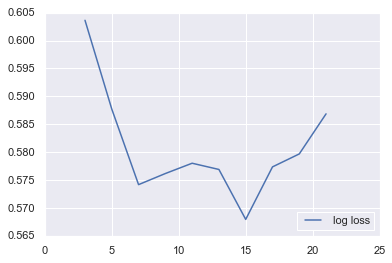

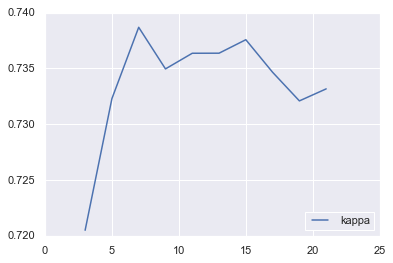

In [51]:
plt.plot(r, errors, label = "log loss")
plt.legend(loc='lower right')
plt.show()
#plt.plot(r, La, label = "accuracy")
plt.plot(r, Lk, label = "kappa")
plt.legend(loc='lower right')
plt.show()

## Cross validation


In [52]:
df = pd.concat([eeg, acc, pulse, naif], axis=1)

In [123]:
df.columns

Index(['eeg1_Delta0', 'eeg1_Theta0', 'eeg1_Alpha0', 'eeg1_Beta0',
       'eeg1_Gamma0', 'eeg2_Delta0', 'eeg2_Theta0', 'eeg2_Alpha0',
       'eeg2_Beta0', 'eeg2_Gamma0',
       ...
       '50%_accelerometer_y', '75%_accelerometer_y', 'mean_accelerometer_z',
       'std_accelerometer_z', 'min_accelerometer_z', 'max_accelerometer_z',
       '25%_accelerometer_z', '50%_accelerometer_z', '75%_accelerometer_z',
       'Y'],
      dtype='object', length=114)

In [128]:
xbc = xgb.XGBClassifier(n_estimators = 180, random_state=42, learning_rate= 0.1, max_depth= 8,  subsample= 0.7, 
                            n_jobs=2, reg_lambda=-1)

In [130]:
%%time 
scores = cross_val_score(xbc, df.iloc[:, :-1], df.iloc[:, -1], cv=5, scoring='neg_log_loss', n_jobs=5)

Wall time: 8min 2s


1 epochs original 


In [140]:
print(scores)
print("mean log loss:", -scores.mean())
print(scores.std())

[-0.7155588  -0.55989686 -0.72403461 -0.76325103 -0.68614813]
mean log loss: 0.6897778877057267
0.06945320186808683


In [131]:
ck_score = make_scorer(cohen_kappa_score, greater_is_better=True))

In [136]:
%%time 
scores2 = cross_val_score(xbc, df.iloc[:, :-1], df.iloc[:, -1], cv=5, scoring=ck_score, n_jobs=5)

Wall time: 8min 23s


In [154]:
print(scores2)
print("kappa:", scores2.mean())
print(scores2.std())

[0.61109626 0.71118463 0.62872865 0.59432452 0.64463099]
kappa: 0.6379930110721268
0.040292125179984505


In [149]:
scoring = ['neg_log_loss': 'neg_log_loss', "kappa": ck_score]

kf = KFold(n_splits=5, shuffle=False)

In [150]:
for train, test in kf.split(df):
    print("%s %s" % (train, test))

[ 8766  8767  8768 ... 43827 43828 43829] [   0    1    2 ... 8763 8764 8765]
[    0     1     2 ... 43827 43828 43829] [ 8766  8767  8768 ... 17529 17530 17531]
[    0     1     2 ... 43827 43828 43829] [17532 17533 17534 ... 26295 26296 26297]
[    0     1     2 ... 43827 43828 43829] [26298 26299 26300 ... 35061 35062 35063]
[    0     1     2 ... 35061 35062 35063] [35064 35065 35066 ... 43827 43828 43829]


In [164]:
skf = StratifiedKFold(n_splits=5)
label = df.iloc[:, -1].unique()
label

array([0, 1, 2, 3, 4], dtype=int64)

In [166]:
for train, test in skf.split(df, df.iloc[:, -1]):
    print("%s %s" % (train, test))

[ 6082  6139  6140 ... 43827 43828 43829] [   0    1    2 ... 9201 9202 9203]
[    0     1     2 ... 43827 43828 43829] [ 6082  6139  6140 ... 21216 21217 21218]
[    0     1     2 ... 43827 43828 43829] [16686 16687 16688 ... 34142 34143 34144]
[    0     1     2 ... 43827 43828 43829] [24658 24659 24660 ... 42076 42077 42078]
[    0     1     2 ... 42076 42077 42078] [33685 33686 33687 ... 43827 43828 43829]


#### will use kf (not stratified) to keep stric order
(though mean kappa is lower with stratified

In [152]:
%%time 
scores3 = cross_val_score(xbc, df.iloc[:, :-1], df.iloc[:, -1], cv=kf, scoring=ck_score, n_jobs=5)

Wall time: 8min 23s


In [155]:
print(scores3)
print("kappa:", scores3.mean())
print(scores3.std())

[0.61841696 0.73107339 0.63352151 0.61514122 0.64955453]
kappa: 0.6495415206179029
0.042558676743570986


## variable selection

In [6]:
df = pd.concat([eeg, acc, pulse, naif], axis=1)
train = df.iloc[0:int(df.shape[0]*0.8), :]
test = df.iloc[int(df.shape[0]*0.8):, :]

In [ ]:
%%time
errors =[]
errors_train = []
Lk = []
Lk_train=[] 
ll_train = []

i=11
train5 = reshape_n(train.iloc[:,:-1], i)

for j in range(0, i//2):
  train5.drop([train5.shape[0]-(i+1)], inplace=True)

test5 = reshape_n(test.iloc[:,:-1], i)
test5["Y"]= test.iloc[:,-1].values
for j in range(0, i//2):
  test5.drop([test5.shape[0]-(i+1)], inplace=True)

X = train5.iloc[:,:-1]
y = train5.iloc[:,-1]
X_test = test5.iloc[:,:-1]
y_true = test5.iloc[:,-1]


xbc = xgb.XGBClassifier(n_estimators = 180, random_state=42, learning_rate= 0.1, max_depth= 8,  subsample= 0.7, 
                        n_jobs=-2, reg_lambda=5, verbose =1)
xbc.fit(X, y)

ll = log_loss(y_true, xbc.predict_proba(X_test))
ll_train = log_loss(y, xbc.predict_proba(X))
errors.append(ll)
errors_train.append(ll_train)
y_pred = xbc.predict(X_test)
k=cohen_kappa_score(y_true, y_pred)
k_train =cohen_kappa_score(y, xbc.predict(X_test))
print("considering ", i, " epochs")
print("log loss = ", ll)
print("log loss train = ", ll_train)
print("kappa = ", k)
print("kappa_train = ", k_train)
Lk.append(k)
Lk_train.append(k_train)


In [ ]:
thresholds = sort(xbc.feature_importances_)

In [ ]:
%%time
thresholds = sort(xbc.feature_importances_)
for thresh in thresholds:
	# select features using threshold
	selection = SelectFromModel(xbc, threshold=thresh, prefit=True)
	select_X_train = selection.transform(X)
	# train model
	selection_model = xgb.XGBClassifier(n_estimators = 180, random_state=42, learning_rate= 0.1, max_depth= 8,  subsample= 0.7, 
                        n_jobs=-2, reg_lambda=5, verbose =1)
	selection_model.fit(select_X_train, y)
	# eval model
	select_X_test = selection.transform(X_test)
	y_pred = selection_model.predict(select_X_test)
    ll = log_loss(y_true, xbc.predict_proba(X_test))
    ll_train = log_loss(y, xbc.predict_proba(X))
    #errors.append(ll)
    #errors.append(ll_train)
    y_pred = xbc.predict(X_test)
    k=cohen_kappa_score(y_true, y_pred)
    k_train =cohen_kappa_score(y, xbc.predict(X_test))
    print("considering ", thresh, " as theshold")
    print("log loss = ", ll)
    print("log loss train = ", ll_train)
    print("kappa = ", k)
    print("kappa_train = ", k_train)
    



#### checking CV on epoch 11 original

best score 0.70273772415489 on 11 epochs
- on training/test: 0.720

In [9]:
%%time
i=11

df = pd.concat([eeg, acc, pulse, naif], axis=1)
train = df.iloc[0:int(df.shape[0]*0.8), :]
test = df.iloc[int(df.shape[0]*0.8):, :]

df11 = reshape_n(df.iloc[:,:-1], i)

for j in range(0, i//2):
  df11.drop([df11.shape[0]-(i+1)], inplace=True)

test5 = reshape_n(test.iloc[:,:-1], i)
test5["Y"]= test.iloc[:,-1].values
for j in range(0, i//2):
  test5.drop([test5.shape[0]-(i+1)], inplace=True)

#X = df11.iloc[:,:-1]
#Y = df11.iloc[:,-1]



Wall time: 3min 13s


In [10]:
kf = KFold(n_splits=5, shuffle=False)

In [ ]:
%%time
errors = []
Lk = []
errors_train = []
Lk_train = []
for df11train, df11test in kf.split(df11):
    X = train11.iloc[:,:-1]
    y = train11.iloc[:,-1]
    X_test = test11.iloc[:,:-1]
    y_true = test11.iloc[:,-1]
          

    xbc = xgb.XGBClassifier(n_estimators = 180, random_state=42, learning_rate= 0.1, max_depth= 8,  subsample= 0.7, 
                            n_jobs=-2, reg_lambda=5)
    xbc.fit(X, y)
    ll = log_loss(y_true, xbc.predict_proba(X_test))
    ll_train = log_loss(y, xbc.predict_proba(X))
    errors.append(ll)
    errors.append(ll_train)
    y_pred = xbc.predict(X_test)
    k=cohen_kappa_score(y_true, y_pred)
    k_train =cohen_kappa_score(y, xbc.predict(X_test))
    print("considering ", i, " epochs")
    print("log loss = ", ll)
    print("kappa = ", k)
    print("kappa_train = ", k_train)
    Lk.append(k)
    Lk_train.append(k_train)

In [11]:
xbc = xgb.XGBClassifier(n_estimators = 180, random_state=42, learning_rate= 0.1, max_depth= 8,  subsample= 0.7, 
                        n_jobs= -2, reg_lambda=5)


ck_score = make_scorer(cohen_kappa_score, greater_is_better=True)
scoring = {'neg_log_loss': 'neg_log_loss', "kappa": ck_score}
#scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}
#scoring = {'AUC': 'roc_auc', 'neg_log_loss': 'neg_log_loss'}

In [ ]:
%%time
ck_score = make_scorer(cohen_kappa_score, greater_is_better=True)
scoring = {'neg_log_loss': 'neg_log_loss', "kappa": ck_score}
kf = KFold(n_splits=5, shuffle=False)
#scores11_original_kf = cross_val_score(xbc, X, Y, cv=kf, scoring=scoring, n_jobs=1)
scores11_original_kf = cross_validate(xbc, X, Y, cv=kf, scoring=scoring, n_jobs=1)

In [6]:
import numpy
L= [0.65092993, 0.72067189, 0.75128558, 0.55002343, 0.67369628]
print(numpy.mean(L))
print(numpy.std(L))

0.669321422
0.0692017211002823


In [ ]:
ck_score = make_scorer(cohen_kappa_score, greater_is_better=True)
scoring = {'neg_log_loss': 'neg_log_loss', "kappa": ck_score}
kf = KFold(n_splits=5, shuffle=False)
scores11_original_kf = cross_validate(xbc, X, Y, cv=kf, scoring=scoring, n_jobs=1)
print("for kfold")
print("neg log loss", scores11_original_kf['test_neg_log_loss'])
print("log loss mean", -scores11_original_kf['test_neg_log_loss'].mean())
print("log loss std", scores11_original_kf['test_neg_log_loss'].std())
print("-----")
print("kappa", scores11_original_kf['test_kappa'])
print("kappa mean", scores11_original_kf['test_kappa'].mean())
print("kappa std", scores11_original_kf['test_kappa'].std())


In [ ]:
%%time
skf = StratifiedKFold(n_splits=5, shuffle=False)
scores11_original_skf = cross_validate(xbc, X, Y, cv=skf, scoring=scoring, n_jobs=5, verbose=1)

In [ ]:
scores['test_recall_macro']
print("for stratified skfold")
print("neg log loss", scores11_original_skf['neg_log_loss'])
print("log loss mean", -scores11_original_skf['neg_log_loss'].mean())
print("log loss std", scores11_original_skf['neg_log_loss'].std())
print("-----")
print("kappa", scores11_original_skf['kappa'])
print("kappa mean", scores11_original_skf['kappa'].mean())
print("kappa std", scores11_original_skf['kappa'].std())

#### investigating lambda regularization for original best score 


In [ ]:
%%time
errors = []
Lk = []
errors_train = []
Lk_train = []

r = [4, 5, 6, 10]

for i in r:
         
    xbc = xgb.XGBClassifier(n_estimators = 180, random_state=42, learning_rate= 0.1, max_depth= 8,  subsample= 0.7, 
                        n_jobs= -1, reg_lambda=i)
    scores = cross_validate(xbc, X, Y, cv=kf, scoring=scoring, n_jobs=1, return_train_score=True, verbose=1)
    xbc.fit(X, y)
    ll = scores['test_neg_log_loss'].mean()
    errors.append(ll)
    k = scores['test_kappa'].mean()
    Lk.append(k)
    
    ll_train = scores['train_neg_log_loss'].mean()
    errors_train.append(ll_train)
    k_train = scores['train_kappa'].mean()
    Lk_train.append(k_train)
    print("reg_lambda ", i)
    print("log loss test = ", ll)
    print("kappa test= ", k)
    print("log loss train = ", ll_train)
    print("kappa train= ", k_train)


In [ ]:
plt.plot(r, errors, label = "log loss test")
plt.plot(r, errors_train, label = "log loss train")
plt.legend(loc='lower right')
plt.show()
plt.plot(r, Lk, label = "kappa test")
plt.plot(r, Lk_train, label = "kappa train")
plt.legend(loc='lower right')
plt.show()

In [57]:
print(df.shape[0]/5)
fold_size= int(df.shape[0]/5)

8766.0


In [83]:
fold = []
fold.append(df[:fold_size])
fold.append(df[fold_size: 2*fold_size])
fold.append(df[fold_size*2: 3*fold_size])
fold.append(df[fold_size*3: 4*fold_size])
fold.append(df[fold_size*4: 5*fold_size])

In [109]:
list(lf[0])

['fold[0]', 'fold[1]', 'fold[2]', 'fold[3]']

In [111]:
train0 = pd.concat([fold[0], fold[1], fold[2], fold[3]])
train1 = pd.concat([fold[0], fold[1], fold[2], fold[4]])
train2 = pd.concat([fold[0], fold[1], fold[3], fold[4]])
train3 = pd.concat([fold[0], fold[2], fold[3], fold[4]])
train4 = pd.concat([fold[1], fold[2], fold[3], fold[4]])


In [121]:
def fold5(df, fold_size): 
    fold = []
    result =[]
    fold.append(df[:fold_size])
    fold.append(df[fold_size: 2*fold_size])
    fold.append(df[fold_size*2: 3*fold_size])
    fold.append(df[fold_size*3: 4*fold_size])
    fold.append(df[fold_size*4: 5*fold_size])
    for i in range(5):
        L=[0, 1, 2, 3, 4, 5]
        L.remove(i)
        s=""
        for j in len(L):
            if (j != len(L)-1):
                s += "fold["+str(j) + ", "
            else:
                s += "fold["+str(j) + "]"
        print(i, s)
    print("toto", s)
            
               

In [118]:
for i in range(5):
    L=[0, 1, 2, 3, 4, 5]
    L.remove(i)
    print(L)

[1, 2, 3, 4, 5]
[0, 2, 3, 4, 5]
[0, 1, 3, 4, 5]
[0, 1, 2, 4, 5]
[0, 1, 2, 3, 5]


In [ ]:
train = df.iloc[0:int(df.shape[0]*0.8), :]
test = df.iloc[int(df.shape[0]*0.8):, :]

In [90]:
train.shape

(35064, 114)

In [ ]:
params = {"n_estimators" : [180], "random_state":[42], "learning_rate" :[0.1], "max_depth" : [8],  "subsample" : [0.7], 
                             "reg_lambda" : [5]}

xbc = xgb.XGBClassifier(n_estimators = 180, random_state=42, max_depth=8, learning_rate=0.1, subsample=0.7)

parametres = { 'reg_lambda' : [0, 1, 5], 'gamma': [0, 0.01], 'reg_alpha' : [0, 1, 5]}
    
ck_score = make_scorer(cohen_kappa_score)
grid = GridSearchCV(estimator=xbc, param_grid=params, scoring='neg_log_loss', n_jobs=-1, verbose=2)

grid_fitted = grid.fit(X,y)
print(grid_fitted.best_params_)

y_pred = grid.predict(X_test)

print("kappa: ", cohen_kappa_score(y_true, y_pred))
print("accurancy for n_estimators  = " , accuracy_score(y_true, y_pred))

# Ancien (as in N Epoch)

In [28]:
errors = []
Lk = []
La = []

X = train.iloc[:,:-1]
y = train.iloc[:,-1]
X_test = test.iloc[:,:-1]
y_true = test.iloc[:,-1]
xbc = xgb.XGBClassifier(n_estimators = 100, random_state=42, learning_rate= 0.1, max_depth= 8,  subsample= 0.7, 
                        n_jobs=-2)
xbc.fit(X, y)
ll = log_loss(y_true, xbc.predict_proba(X_test))
errors.append(ll)
y_pred = xbc.predict(X_test)
k=cohen_kappa_score(y_true, y_pred)
a= accuracy_score(y_true, y_pred)
print("considering only one epoch")
print("log loss = ", ll)
print("kappa = ", k)
print("accuracy = ", a)
Lk.append(k)
La.append(a)

r = [3, 5, 7, 9, 11]

for i in r:
    train5 = reshape_n(train.iloc[:,:-1], i)
    train5["Y"]= train.iloc[:,-1]

    for j in range(0, i//2):
      train5.drop([train5.shape[0]-(i+1)], inplace=True)
    
    test5 = reshape_n(test.iloc[:,:-1], i)
    test5["Y"]= test.iloc[:,-1].values
    for j in range(0, i//2):
      test5.drop([test5.shape[0]-(i+1)], inplace=True)
      
    X = train5.iloc[:,:-1]
    y = train5.iloc[:,-1]
    X_test = test5.iloc[:,:-1]
    y_true = test5.iloc[:,-1]
          
    xbc = xgb.XGBClassifier(n_estimators = 100, random_state=42, learning_rate= 0.1, max_depth= 8,  
                            subsample= 0.7, n_jobs=-2)
    xbc.fit(X, y)
    ll = log_loss(y_true, xbc.predict_proba(X_test))
    errors.append(ll)
    y_pred = xbc.predict(X_test)
    k=cohen_kappa_score(y_true, y_pred)
    a= accuracy_score(y_true, y_pred)
    print("considering ", i, " epochs")
    print("log loss = ", ll)
    print("kappa = ", k)
    print("accuracy = ", a)
    Lk.append(k)
    La.append(a)

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


considering only one epoch
log loss =  0.7112616548593073
kappa =  0.6481903133115836
accuracy =  0.7408167921514944


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


considering  3  epochs
log loss =  0.6144416170129664
kappa =  0.704377782967301
accuracy =  0.7824301197946377


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


considering  5  epochs
log loss =  0.6146555564059356
kappa =  0.7021318471786651
accuracy =  0.7806937471474212


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


considering  7  epochs
log loss =  0.6108590127670228
kappa =  0.7049457851705652
accuracy =  0.7827228118224352


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


considering  9  epochs
log loss =  0.6089801103144198
kappa =  0.702750750259022
accuracy =  0.7813284638210454
considering  11  epochs
log loss =  0.6070592229998082
kappa =  0.7129564405419131
accuracy =  0.7888368907658942


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [29]:
 r.insert(0, 1)

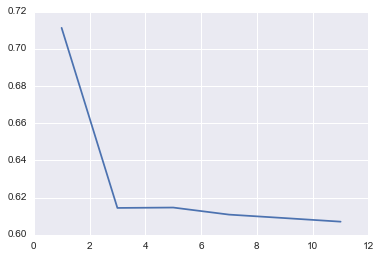

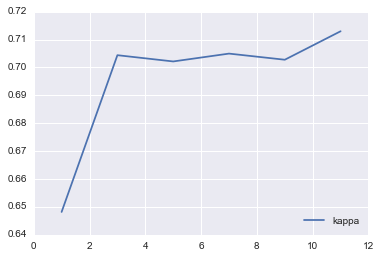

In [30]:
plt.plot(r, errors, label = "log loss")
plt.legend(loc='lower right')
plt.show()
#plt.plot(r, La, label = "accuracy")
plt.plot(r, Lk, label = "kappa")
plt.legend(loc='lower right')
plt.show()

In [33]:
errors = []
Lk = []
La = []

X = train.iloc[:,:-1]
y = train.iloc[:,-1]
X_test = test.iloc[:,:-1]
y_true = test.iloc[:,-1]
xbc = xgb.XGBClassifier(n_estimators = 180, random_state=42, learning_rate= 0.1, max_depth= 8,  subsample= 0.7, 
                        n_jobs=-2)
xbc.fit(X, y)
ll = log_loss(y_true, xbc.predict_proba(X_test))
errors.append(ll)
y_pred = xbc.predict(X_test)
k=cohen_kappa_score(y_true, y_pred)
a= accuracy_score(y_true, y_pred)
print("considering only one epoch")
print("log loss = ", ll)
print("kappa = ", k)
print("accuracy = ", a)
Lk.append(k)
La.append(a)

r = [3, 5, 7, 9, 11, 13, 15, 17, 19, 21]

for i in r:
    train5 = reshape_n(train.iloc[:,:-1], i)
    train5["Y"]= train.iloc[:,-1]

    for j in range(0, i//2):
      train5.drop([train5.shape[0]-(i+1)], inplace=True)
    
    test5 = reshape_n(test.iloc[:,:-1], i)
    test5["Y"]= test.iloc[:,-1].values
    for j in range(0, i//2):
      test5.drop([test5.shape[0]-(i+1)], inplace=True)
      
    X = train5.iloc[:,:-1]
    y = train5.iloc[:,-1]
    X_test = test5.iloc[:,:-1]
    y_true = test5.iloc[:,-1]
          
    xbc = xgb.XGBClassifier(n_estimators = 180, random_state=42, learning_rate= 0.1, max_depth= 8,  
                            subsample= 0.7, n_jobs=-2)
    xbc.fit(X, y)
    ll = log_loss(y_true, xbc.predict_proba(X_test))
    errors.append(ll)
    y_pred = xbc.predict(X_test)
    k=cohen_kappa_score(y_true, y_pred)
    a= accuracy_score(y_true, y_pred)
    print("considering ", i, " epochs")
    print("log loss = ", ll)
    print("kappa = ", k)
    print("accuracy = ", a)
    Lk.append(k)
    La.append(a)

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


considering only one epoch
log loss =  0.7365930790570688
kappa =  0.6500303924229641
accuracy =  0.742299794661191


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


considering  3  epochs
log loss =  0.6395421070551731
kappa =  0.7102063541106889
accuracy =  0.7867655447803765


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


considering  5  epochs
log loss =  0.6345323343079022
kappa =  0.7152280046605096
accuracy =  0.7903925148334094


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


considering  7  epochs
log loss =  0.6351625698814416
kappa =  0.7130812067465442
accuracy =  0.7887709688462855


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


considering  9  epochs
log loss =  0.6314540491602866
kappa =  0.7125095971872804
accuracy =  0.7885186030586624


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


considering  11  epochs
log loss =  0.6321143030558676
kappa =  0.7216579296679757
accuracy =  0.7953429973747289


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


considering  13  epochs
log loss =  0.6243029429858097
kappa =  0.7193243794893144
accuracy =  0.7934931506849315


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


considering  15  epochs
log loss =  0.6240693668764069
kappa =  0.7219510879454714
accuracy =  0.7957529398333143


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


considering  17  epochs
log loss =  0.6205331297616722
kappa =  0.72081410122745
accuracy =  0.7947019867549668


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


considering  19  epochs
log loss =  0.6324855365028789
kappa =  0.7169432839060098
accuracy =  0.7918236839100149
considering  21  epochs
log loss =  0.6422925560275619
kappa =  0.7129084211931155
accuracy =  0.78905893101873


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


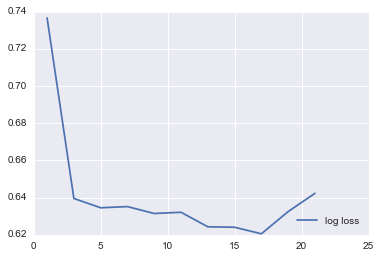

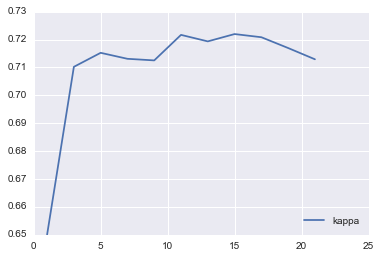

In [34]:
r.insert(0, 1)
plt.plot(r, errors, label = "log loss")
plt.legend(loc='lower right')
plt.show()
#plt.plot(r, La, label = "accuracy")
plt.plot(r, Lk, label = "kappa")
plt.legend(loc='lower right')
plt.show()

Explore for 11 epochs (epoch + 5 minutes before and 5 minutes after)

In [9]:
#Explore for 11 epochs (epoch + 5 minutes before and 5 minutes after)
i=11
train5 = reshape_n(train.iloc[:,:-1], i)
train5["Y"]= train.iloc[:,-1]

for j in range(0, i//2):
  train5.drop([train5.shape[0]-(i+1)], inplace=True)

test5 = reshape_n(test.iloc[:,:-1], i)
test5["Y"]= test.iloc[:,-1].values
for j in range(0, i//2):
  test5.drop([test5.shape[0]-(i+1)], inplace=True)

X = train5.iloc[:,:-1]
y = train5.iloc[:,-1]
X_test = test5.iloc[:,:-1]
y_true = test5.iloc[:,-1]

In [36]:
errors = []
Lk = []
La = []

r = range(10, 500 , 10)

for i in r:
    xbc = xgb.XGBClassifier(n_estimators = i, random_state=42, learning_rate= 0.1, max_depth= 8,  subsample= 0.7, 
                            n_jobs=-2, warm_start=True)
    xbc.fit(X, y)
    ll = log_loss(y_true, xbc.predict_proba(X_test))
    errors.append(ll)
    y_pred = xbc.predict(X_test)
    k=cohen_kappa_score(y_true, y_pred)
    a= accuracy_score(y_true, y_pred)
    print("for n_estimators= ", i)
    print("log loss = ", ll)
    print("kappa = ", k)
    print("accuracy = ", a)
    
    Lk.append(k)
    La.append(a)
    xbc.fit(X, y).n_estimators += 10

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  10
log loss =  0.9824693852629703
kappa =  0.6502332207149977
accuracy =  0.7415820111859377


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  20
log loss =  0.7891275199403802
kappa =  0.6618292188900556
accuracy =  0.7500285355553019


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  30
log loss =  0.6955273778901404
kappa =  0.6775739024792471
accuracy =  0.7622417532245177


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  40
log loss =  0.6550531071676551
kappa =  0.6900234277655801
accuracy =  0.771601415363543


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  50
log loss =  0.6345224660584097
kappa =  0.691702092988979
accuracy =  0.7728569797968269


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  60
log loss =  0.6258373713162702
kappa =  0.6912880739446804
accuracy =  0.7724004109119963


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  70
log loss =  0.6177249742773261
kappa =  0.6979011085827476
accuracy =  0.7774226686451319


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  80
log loss =  0.6112047357619916
kappa =  0.7049871818939144
accuracy =  0.7827873530418902


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  90
log loss =  0.607499615408862
kappa =  0.709000268962936
accuracy =  0.7858691930144961


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  100
log loss =  0.6070592229998082
kappa =  0.7129564405419131
accuracy =  0.7888368907658942


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  110
log loss =  0.6066953947836593
kappa =  0.7144819405077073
accuracy =  0.7899783129779705


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  120
log loss =  0.6084892356102274
kappa =  0.7163606786066179
accuracy =  0.791348019632462


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  130
log loss =  0.6106290467241953
kappa =  0.7188981599880631
accuracy =  0.7932884373929917


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  140
log loss =  0.6166908316598455
kappa =  0.7170786833522892
accuracy =  0.7919187307385002


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  150
log loss =  0.6207472471339629
kappa =  0.7181754142114944
accuracy =  0.7928318685081611


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  160
log loss =  0.6224779050881721
kappa =  0.7195402438540016
accuracy =  0.7937450062778222


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  170
log loss =  0.626628714786645
kappa =  0.719101727663049
accuracy =  0.7934025796141992


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  180
log loss =  0.6321143030558676
kappa =  0.7216579296679757
accuracy =  0.7953429973747289


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  190
log loss =  0.6352768290933914
kappa =  0.7216055086748873
accuracy =  0.7952288551535213


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  200
log loss =  0.6381782097930583
kappa =  0.7211436803974731
accuracy =  0.7948864284898984


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  210
log loss =  0.6419448228768974
kappa =  0.7226490987849138
accuracy =  0.7960278507019747


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  220
log loss =  0.6452712231765992
kappa =  0.7236143614158422
accuracy =  0.7967127040292205


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  230
log loss =  0.648524599123075
kappa =  0.7231392218614955
accuracy =  0.7963702773655975


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  240
log loss =  0.6521031259115087
kappa =  0.7241173315038751
accuracy =  0.7970551306928433


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  250
log loss =  0.6553704103977813
kappa =  0.7261231064474428
accuracy =  0.7985389795685424


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  260
log loss =  0.6578860077299948
kappa =  0.7272343578805749
accuracy =  0.7993379751169958


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  270
log loss =  0.66123282243177
kappa =  0.7278202163159542
accuracy =  0.7997945440018263


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  280
log loss =  0.664549875559046
kappa =  0.7268106892607163
accuracy =  0.798995548453373


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  290
log loss =  0.6671634522260086
kappa =  0.7264769620312701
accuracy =  0.7987672640109577


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  300
log loss =  0.6707836514828428
kappa =  0.7262274556566863
accuracy =  0.7985389795685424


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  310
log loss =  0.6739803170293677
kappa =  0.7256234321439765
accuracy =  0.7980824106837119


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  320
log loss =  0.67660783282511
kappa =  0.725615062421643
accuracy =  0.7980824106837119


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  330
log loss =  0.6796034779831235
kappa =  0.7256406120344676
accuracy =  0.7980824106837119


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  340
log loss =  0.6829155090210953
kappa =  0.7263612604815823
accuracy =  0.79865312178975


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  350
log loss =  0.6861745049173499
kappa =  0.7268462542262766
accuracy =  0.798995548453373


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  360
log loss =  0.689095421662188
kappa =  0.7276448003133367
accuracy =  0.7995662595594111


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  370
log loss =  0.6916870469914217
kappa =  0.7261493569293465
accuracy =  0.7984248373473348


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  380
log loss =  0.6936667238937615
kappa =  0.7267403684404221
accuracy =  0.7988814062321653


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  390
log loss =  0.696573289752853
kappa =  0.7267209458214867
accuracy =  0.7988814062321653


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  400
log loss =  0.6996342898326563
kappa =  0.7273373135800636
accuracy =  0.7993379751169958


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  410
log loss =  0.7016625697535597
kappa =  0.7271509776963712
accuracy =  0.7992238328957881


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  420
log loss =  0.7044588621553853
kappa =  0.7282147360530937
accuracy =  0.8000228284442416


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  430
log loss =  0.7069143016715345
kappa =  0.7276039936357956
accuracy =  0.7995662595594111


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  440
log loss =  0.7088032159571778
kappa =  0.7287103847696134
accuracy =  0.8003652551078644


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  450
log loss =  0.7106005472981862
kappa =  0.7287540044349627
accuracy =  0.8003652551078644


KeyboardInterrupt: 

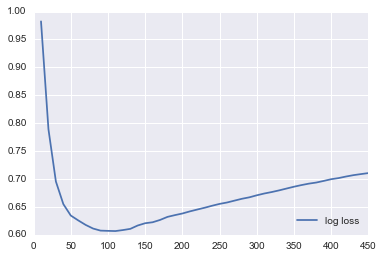

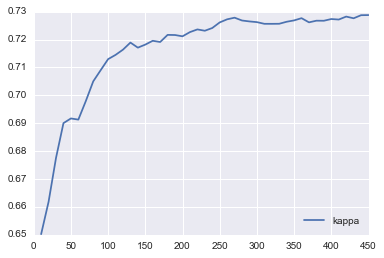

In [38]:
rr = range(10, 460 , 10)
plt.plot(rr, errors, label = "log loss")
plt.legend(loc='lower right')
plt.show()
#plt.plot(rr, La, label = "accuracy")
plt.plot(rr, Lk, label = "kappa")
plt.legend(loc='lower right')
plt.show()


n=100. Score: 0.692 compared to 0.691 with N=5
- log loss =  0.6070592229998082
- kappa =  0.7129564405419131
- accuracy =  0.7888368907658942

log loss minimized for n_estimators=  110
- log loss =  0.6066953947836593
- kappa =  0.7144819405077073
- accuracy =  0.7899783129779705

1st max kappa
- for n_estimators=  270
- log loss =  0.66123282243177
- kappa =  0.7278202163159542
- accuracy =  0.7997945440018263

let's see if regularisation help for n = 270

In [39]:
errors = []
Lk = []
La = []

r = range(120, 370 , 50)
xbc = xgb.XGBClassifier(n_estimators = 120, random_state=42, learning_rate= 0.1, max_depth= 8,  subsample= 0.7, 
                            n_jobs=-2, warm_start=True, lambda_reg=5)

for i in r:
    xbc.fit(X, y)
    ll = log_loss(y_true, xbc.predict_proba(X_test))
    errors.append(ll)
    y_pred = xbc.predict(X_test)
    k=cohen_kappa_score(y_true, y_pred)
    a= accuracy_score(y_true, y_pred)
    print("for n_estimators= ", i)
    print("log loss = ", ll)
    print("kappa = ", k)
    print("accuracy = ", a)
    
    Lk.append(k)
    La.append(a)
    xbc.fit(X, y).n_estimators += 50

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  120
log loss =  0.6084892356102274
kappa =  0.7163606786066179
accuracy =  0.791348019632462


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  170
log loss =  0.626628714786645
kappa =  0.719101727663049
accuracy =  0.7934025796141992


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  220
log loss =  0.6452712231765992
kappa =  0.7236143614158422
accuracy =  0.7967127040292205


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  270
log loss =  0.66123282243177
kappa =  0.7278202163159542
accuracy =  0.7997945440018263


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  320
log loss =  0.67660783282511
kappa =  0.725615062421643
accuracy =  0.7980824106837119


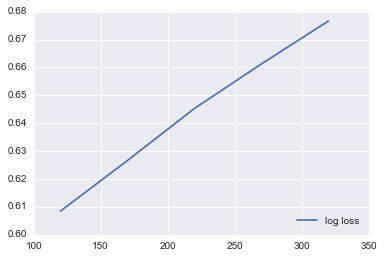

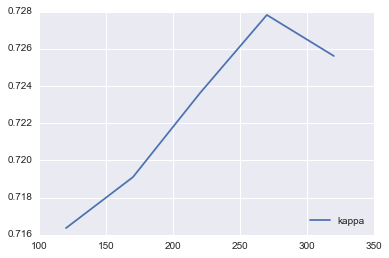

In [40]:
plt.plot(r, errors, label = "log loss")
plt.legend(loc='lower right')
plt.show()
#plt.plot(r, La, label = "accuracy")
plt.plot(r, Lk, label = "kappa")
plt.legend(loc='lower right')
plt.show()

In [13]:
xbc = xgb.XGBClassifier(n_estimators = 180, random_state=42, max_depth=8, learning_rate=0.1, subsample=0.7)

parametres = { 'reg_lambda' : [0, 1, 5], 'gamma': [0, 0.01], 'reg_alpha' : [0, 1, 5]}
    
ck_score = make_scorer(cohen_kappa_score)
grid = GridSearchCV(estimator=xbc, param_grid=parametres, scoring='neg_log_loss', n_jobs=-1, verbose=2)

grid_fitted = grid.fit(X,y)
print(grid_fitted.best_params_)

y_pred = grid.predict(X_test)

print("kappa: ", cohen_kappa_score(y_true, y_pred))
print("accurancy for n_estimators  = " , accuracy_score(y_true, y_pred))

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 317.6min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed: 549.4min finished


{'gamma': 0.01, 'reg_alpha': 5, 'reg_lambda': 5}
kappa:  0.7110410355251684
accurancy for n_estimators  =  0.7865540463417419


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [15]:
ll = log_loss(y_true, grid.predict_proba(X_test))
ll

0.5847366368019232

Reference without regularization n: 180
- log loss =  0.632
- kappa =  0.722
- accuracy =  0.795
n estimator : 180, {'gamma': 0.01, 'reg_alpha': 5, 'reg_lambda': 5}
- log loss: 0.585
- kappa:  0.711
- accurancy: 0.787
for n_estimators=  240 {'gamma': 0.01, 'reg_alpha': 5, 'reg_lambda': 5} // log loss min 
- log loss =  0.5805557190155572
- kappa =  0.719 /  
- accuracy =  0.792
- challenge score : 0.69501856567217. Delta test/Challenge 0,7186789415933239- 0,69501856567217= 0.024
for n_estimators=  300 {'gamma': 0.01, 'reg_alpha': 5, 'reg_lambda': 5} // point d'interret
- log loss =  0.580970969589507
- kappa =  0.7218863968707475
- accuracy =  0.7947722862686908
for n_estimators=  340 {'gamma': 0.01, 'reg_alpha': 5, 'reg_lambda': 5} // point d'interret
- log loss =  0.5826844474036029
- kappa =  0.7242661136765393
- accuracy =  0.7965985618080128
- Your score is : 0.69083908105379. Moins que n = 240 faut arreter la.


In [16]:
errors = []
Lk = []
La = []

r = range(100, 420 , 20)

xbc = xgb.XGBClassifier(n_estimators = 100, random_state=42, learning_rate= 0.1, max_depth= 8,  subsample= 0.7, 
                            n_jobs=-2, warm_start=True, reg_lambda=5, reg_alpha=5, gamma=0.01)
for i in r:

    xbc.fit(X, y)
    ll = log_loss(y_true, xbc.predict_proba(X_test))
    errors.append(ll)
    y_pred = xbc.predict(X_test)
    k=cohen_kappa_score(y_true, y_pred)
    a= accuracy_score(y_true, y_pred)
    print("for n_estimators= ", i)
    print("log loss = ", ll)
    print("kappa = ", k)
    print("accuracy = ", a)
    
    Lk.append(k)
    La.append(a)
    xbc.fit(X, y).n_estimators += 20

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  100
log loss =  0.5943547207077089
kappa =  0.6953217264061219
accuracy =  0.7745691131149413


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  120
log loss =  0.590197229433441
kappa =  0.6999629943324568
accuracy =  0.7781075219723775


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  140
log loss =  0.5869327156193311
kappa =  0.7032713552774696
accuracy =  0.7806186508389453


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  160
log loss =  0.5850630449359749
kappa =  0.7070735575692861
accuracy =  0.783472206369136


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  180
log loss =  0.5847366368019232
kappa =  0.7110410355251684
accuracy =  0.7865540463417419


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  200
log loss =  0.582801791101916
kappa =  0.7143070254961257
accuracy =  0.7890651752083095


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  220
log loss =  0.5822019173799158
kappa =  0.7163987924076292
accuracy =  0.7906631663052163


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  240
log loss =  0.5805557190155572
kappa =  0.7186789415933239
accuracy =  0.7923752996233306


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  260
log loss =  0.5807101228630106
kappa =  0.7201279602809887
accuracy =  0.7935167218354069


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  280
log loss =  0.5814518261065713
kappa =  0.7206615574207387
accuracy =  0.7938591484990298


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  300
log loss =  0.580970969589507
kappa =  0.7218863968707475
accuracy =  0.7947722862686908


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  320
log loss =  0.582533653043016
kappa =  0.7226209636720686
accuracy =  0.7953429973747289


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  340
log loss =  0.5826844474036029
kappa =  0.7242661136765393
accuracy =  0.7965985618080128


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  360
log loss =  0.5850286402342671
kappa =  0.7241194545510675
accuracy =  0.7964844195868052


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  380
log loss =  0.586012107670894
kappa =  0.724427042245402
accuracy =  0.7967127040292205


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  400
log loss =  0.588075511257475
kappa =  0.7253034446344182
accuracy =  0.7973975573564661


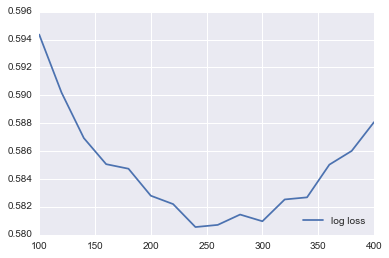

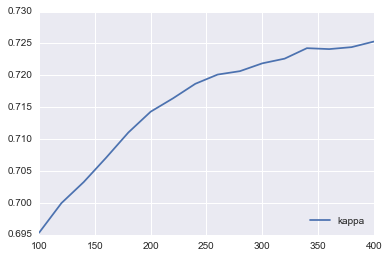

In [17]:
plt.plot(r, errors, label = "log loss")
plt.legend(loc='lower right')
plt.show()
#plt.plot(r, La, label = "accuracy")
plt.plot(r, Lk, label = "kappa")
plt.legend(loc='lower right')
plt.show()

#### trying with 17 epochs (to make sure)
- submitted for estimators = 150 | 180 with score a bit below 0.70

In [7]:
#Explore for 11 epochs (epoch + 5 minutes before and 5 minutes after)
i=17
train5 = reshape_n(train.iloc[:,:-1], i)
train5["Y"]= train.iloc[:,-1]

for j in range(0, i//2):
  train5.drop([train5.shape[0]-(i+1)], inplace=True)

test5 = reshape_n(test.iloc[:,:-1], i)
test5["Y"]= test.iloc[:,-1].values
for j in range(0, i//2):
  test5.drop([test5.shape[0]-(i+1)], inplace=True)

X = train5.iloc[:,:-1]
y = train5.iloc[:,-1]
X_test = test5.iloc[:,:-1]
y_true = test5.iloc[:,-1]

In [8]:
X.shape

(35056, 1921)

In [9]:
errors = []
Lk = []
La = []

r = range(10, 210 , 10)


for i in r:
    xbc = xgb.XGBClassifier(n_estimators = i, random_state=42, learning_rate= 0.1, max_depth= 8,  subsample= 0.7, 
                            n_jobs=-1, warm_start=True, lambda_reg=5)
    xbc.fit(X, y)
    ll = log_loss(y_true, xbc.predict_proba(X_test))
    errors.append(ll)
    y_pred = xbc.predict(X_test)
    k=cohen_kappa_score(y_true, y_pred)
    a= accuracy_score(y_true, y_pred)
    print("for n_estimators= ", i)
    print("log loss = ", ll)
    print("kappa = ", k)
    print("accuracy = ", a)
    
    Lk.append(k)
    La.append(a)
    



C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  10
log loss =  0.9625536626803328
kappa =  0.6717997514835425
accuracy =  0.7589632336149806


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  20
log loss =  0.761683596277256
kappa =  0.6825550017918228
accuracy =  0.7667275633706325


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  30
log loss =  0.6748793622107505
kappa =  0.6876622140614548
accuracy =  0.7704955469285225


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  40
log loss =  0.6378810095244971
kappa =  0.6946384995809091
accuracy =  0.7756337063256451


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  50
log loss =  0.6152916663766782
kappa =  0.6997561595972327
accuracy =  0.7794016898835351


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  60
log loss =  0.6040492944089093
kappa =  0.7023227437103737
accuracy =  0.781228591002512


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  70
log loss =  0.5960098088023064
kappa =  0.7039463327631735
accuracy =  0.7823704042018725


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  80
log loss =  0.5922166254881782
kappa =  0.7075261466132107
accuracy =  0.784996574560402


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  90
log loss =  0.5911915861204144
kappa =  0.7106478852977616
accuracy =  0.7872802009591231


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  100
log loss =  0.594254732468842
kappa =  0.7136797501582159
accuracy =  0.7895638273578443


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  110
log loss =  0.5968741104844192
kappa =  0.7137883615475002
accuracy =  0.7896780086777803


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  120
log loss =  0.599550031839922
kappa =  0.7147794020883436
accuracy =  0.7904772779173327


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  130
log loss =  0.6019848179209207
kappa =  0.716240509527251
accuracy =  0.7915049097967573


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  140
log loss =  0.6050395928337824
kappa =  0.7165602958451522
accuracy =  0.7917332724366294


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  150
log loss =  0.6096242395361352
kappa =  0.7193654248905181
accuracy =  0.7937885361954784


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  160
log loss =  0.613080168420413
kappa =  0.7191047470350179
accuracy =  0.7935601735556063


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  170
log loss =  0.6180097216089501
kappa =  0.719327843494894
accuracy =  0.7936743548755424


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  180
log loss =  0.6205331297616722
kappa =  0.72081410122745
accuracy =  0.7947019867549668


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  190
log loss =  0.6247364707547473
kappa =  0.721309318148897
accuracy =  0.7950445307147751
for n_estimators=  200
log loss =  0.6284810938370645
kappa =  0.722819914459975
accuracy =  0.7961863439141357


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


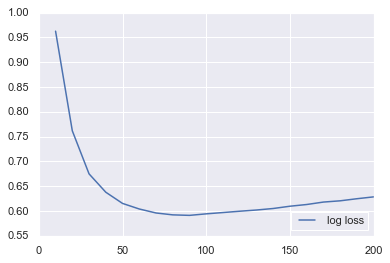

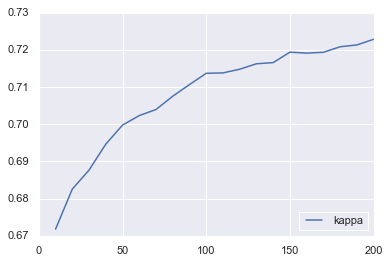

In [10]:
plt.plot(r, errors, label = "log loss")
plt.legend(loc='lower right')
plt.show()
#plt.plot(r, La, label = "accuracy")
plt.plot(r, Lk, label = "kappa")
plt.legend(loc='lower right')
plt.show()

#### Illustrating best score
 
 your score 0.70273772415489
xbc = xgb.XGBClassifier(n_estimators = 180, random_state=42, learning_rate= 0.1, max_depth= 8,  subsample= 0.7, 
                            n_jobs=-2, reg_lambda=5)

In [23]:
#Explore for 11 epochs (epoch + 5 minutes before and 5 minutes after)
i=11
train5 = reshape_n(train.iloc[:,:-1], i)
train5["Y"]= train.iloc[:,-1]

for j in range(0, i//2):
  train5.drop([train5.shape[0]-(i+1)], inplace=True)

test5 = reshape_n(test.iloc[:,:-1], i)
test5["Y"]= test.iloc[:,-1].values
for j in range(0, i//2):
  test5.drop([test5.shape[0]-(i+1)], inplace=True)

X = train5.iloc[:,:-1]
y = train5.iloc[:,-1]
X_test = test5.iloc[:,:-1]
y_true = test5.iloc[:,-1]

In [24]:
xbc = xgb.XGBClassifier(n_estimators = 180, random_state=42, learning_rate= 0.1, max_depth= 8,  subsample= 0.7, 
                            n_jobs=-2, reg_lambda=5)


In [25]:
xbc.fit(X, y)
ll = log_loss(y_true, xbc.predict_proba(X_test))
errors.append(ll)
y_pred = xbc.predict(X_test)
k=cohen_kappa_score(y_true, y_pred)
a= accuracy_score(y_true, y_pred)
print("for n_estimators= ", i)
print("log loss = ", ll)
print("kappa = ", k)
print("accuracy = ", a)

for n_estimators=  11
log loss =  0.6064331996516102
kappa =  0.719398312246695
accuracy =  0.7934025796141992


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [26]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1642   36  150    9   96]
 [  44   10   67    0  122]
 [  33    7 2322  260  249]
 [  26    0  429 2079    0]
 [  26    3  247    6  898]]
Normalized confusion matrix
[[0.85 0.02 0.08 0.   0.05]
 [0.18 0.04 0.28 0.   0.5 ]
 [0.01 0.   0.81 0.09 0.09]
 [0.01 0.   0.17 0.82 0.  ]
 [0.02 0.   0.21 0.01 0.76]]


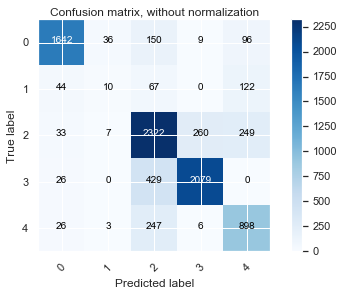

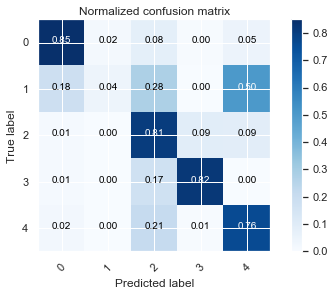

In [27]:

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0, 1, 2, 3, 4], title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0, 1, 2, 3, 4], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

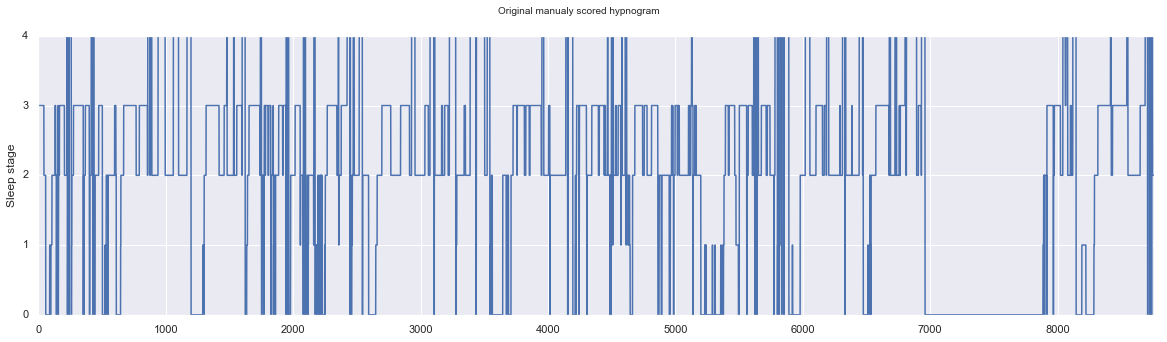

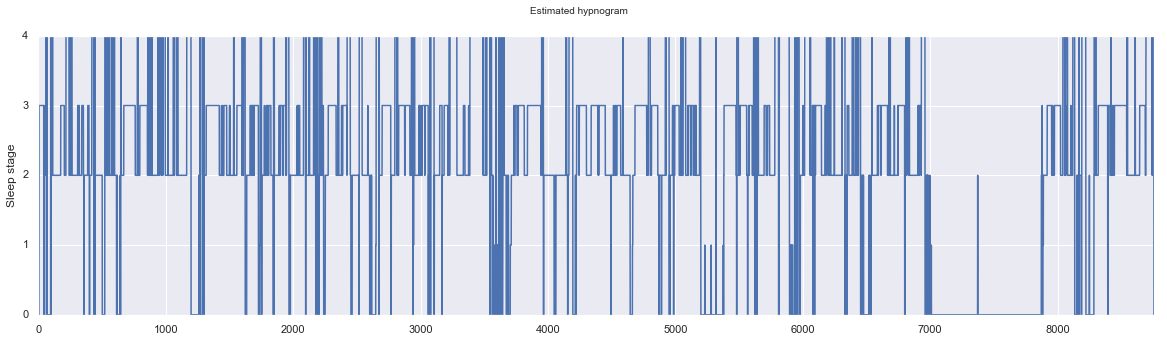

In [28]:
lim = y_pred.shape[0]

fig, ax = plt.subplots(figsize=(20,5))
plt.plot(y_true)
plt.ylabel('Sleep stage')
plt.yticks([0, 1, 2, 3, 4, ])
ax.set_xlim([0, lim])
fig.suptitle("Original manualy scored hypnogram")
plt.show()


fig, ax = plt.subplots(figsize=(20,5))
plt.plot(y_pred)
plt.ylabel('Sleep stage')
plt.yticks([0, 1, 2, 3, 4, ])
ax.set_xlim([0, lim])
fig.suptitle("Estimated hypnogram")
plt.show()

## Trying stacking 

reference boosting
for n_estimators=  11
log loss =  0.6064331996516102
kappa =  0.719398312246695
accuracy =  0.7934025796141992

XGboost on XGboost: exactly the same challenge score

In [15]:
naif = pd.read_excel('C:\\Users\\i053131\\Desktop\\Epilepsie\\Dreem\\data\\interim\\featuresTrain.xlsx')
eeg = pd.read_excel('C:\\Users\\i053131\\Desktop\\Epilepsie\\Dreem\\data\\interim\\spectrogram_eeg_features30Train.xlsx')
acc = pd.read_excel('C:\\Users\\i053131\\Desktop\\Epilepsie\\Dreem\\data\\interim\\acc_featuresTrain.xlsx')
pulse = pd.read_csv('C:\\Users\\i053131\\Desktop\\Epilepsie\\Dreem\\data\\interim\\pulse_featuresTrain.csv')
pulse = pulse.iloc[:, 1:]  
eeg.drop(columns=["eeg1_Above100Hz0", "eeg2_Above100Hz0", "eeg3_Above100Hz0", "eeg4_Above100Hz0"], inplace=True)
df = pd.concat([eeg, acc, pulse, naif], axis=1)

train = df.iloc[0:int(df.shape[0]*0.8), :]
test = df.iloc[int(df.shape[0]*0.8):, :]


In [4]:
i=11
train5 = reshape_n(train.iloc[:,:-1], i)
train5["Y"]= train.iloc[:,-1]

for j in range(0, i//2):
  train5.drop([train5.shape[0]-(i+1)], inplace=True)

test5 = reshape_n(test.iloc[:,:-1], i)
test5["Y"]= test.iloc[:,-1].values
for j in range(0, i//2):
  test5.drop([test5.shape[0]-(i+1)], inplace=True)

X = train5.iloc[:,:-1]

X_test = test5.iloc[:,:-1]
y_true = test5.iloc[:,-1]
y = train5.iloc[:,-1]
y_true = test5.iloc[:,-1]

In [40]:
y.isna().any()

False

In [5]:
xbc = xgb.XGBClassifier(n_estimators = 180, random_state=42, learning_rate= 0.1, max_depth= 8,  subsample= 0.7, 
                            n_jobs=-2, reg_lambda=5)

In [6]:
xbc.fit(X, y)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=8, min_child_weight=1, missing=None, n_estimators=180,
       n_jobs=-2, nthread=None, objective='multi:softprob',
       random_state=42, reg_alpha=0, reg_lambda=5, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.7)

In [7]:
proba_X_test = xbc.predict_proba(X_test)
proba_X = xbc.predict_proba(X)
ll = log_loss(y_true, proba_X_test)

y_pred = xbc.predict(X_test)
k=cohen_kappa_score(y_true, y_pred)
a= accuracy_score(y_true, y_pred)
print("for n_estimators= ", i)
print("log loss = ", ll)
print("kappa = ", k)
print("accuracy = ", a)

for n_estimators=  11
log loss =  0.6064331996516102
kappa =  0.719398312246695
accuracy =  0.7934025796141992


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [43]:
tmp = pd.DataFrame(proba_X)
i=11
train_proba11 = reshape_n(tmp, i)
train_proba11["Y"]= y.values

for j in range(0, i//2):
  train_proba11.drop([train_proba11.shape[0]-(i+1)], inplace=True)

In [48]:
tmp2 = pd.DataFrame(proba_X_test)
i=11
test_proba11 = reshape_n(tmp2, i)
test_proba11["Y"]= y_true.values
for j in range(0, i//2):
  test_proba11.drop([test_proba11.shape[0]-(i+1)], inplace=True)



In [44]:
train_proba11.shape

(35054, 56)

In [47]:
train_proba11["Y"].shape

(35054,)

In [49]:
train_proba11.to_excel('C:\\Users\\i053131\\Desktop\\Epilepsie\\Dreem\\data\\interim\\proba11train.xlsx')
test_proba11.to_excel('C:\\Users\\i053131\\Desktop\\Epilepsie\\Dreem\\data\\interim\\proba11test.xlsx')

In [56]:
X = train_proba11.iloc[:,:-1]
y = train_proba11.iloc[:,-1]
X_test = test_proba11.iloc[:,:-1]
y_true = test_proba11.iloc[:,-1]

In [57]:
xbcs = xgb.XGBClassifier(n_estimators = 17, random_state=42, learning_rate= 0.1, max_depth= 2,  subsample= 0.7, 
                            n_jobs=-2)

In [60]:
xbcs.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=17,
       n_jobs=-2, nthread=None, objective='multi:softprob',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.7)

In [62]:
y_pred = xbcs.predict(X_test)
k=cohen_kappa_score(y_true, y_pred)
a= accuracy_score(y_true, y_pred)
print("for n_estimators= 17")

print("kappa = ", k)
print("accuracy = ", a)

for n_estimators= 17
kappa =  0.7239401652315347
accuracy =  0.7964824120603015


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [45]:
errors = []
Lk = []
La = []

r = range(10, 21)


for i in r:
    xbcs = xgb.XGBClassifier(n_estimators = i, random_state=42, learning_rate= 0.1, max_depth= 2,  subsample= 0.7, 
                            n_jobs=-1)
    xbcs.fit(train_proba11, y)
    ll = log_loss(y_true, xbcs.predict_proba(test_proba11))
    errors.append(ll)
    y_pred = xbcs.predict(test_proba11)
    k=cohen_kappa_score(y_true, y_pred)
    a= accuracy_score(y_true, y_pred)
    print("n_estimators= ", i)
    print("log loss = ", ll)
    print("kappa = ", k)
    print("accuracy = ", a)
    
    Lk.append(k)
    La.append(a)

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


n_estimators=  10
log loss =  0.84270418470968
kappa =  0.7226350792682641
accuracy =  0.7955712818171442


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


n_estimators=  11
log loss =  0.8215997511496107
kappa =  0.7228571249827118
accuracy =  0.7956854240383517


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


n_estimators=  12
log loss =  0.8051402936983484
kappa =  0.7228571249827118
accuracy =  0.7956854240383517


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


n_estimators=  13
log loss =  0.7924595574696659
kappa =  0.7228571249827118
accuracy =  0.7956854240383517


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


n_estimators=  14
log loss =  0.7831160741205588
kappa =  0.722840559645325
accuracy =  0.7956854240383517


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


n_estimators=  15
log loss =  0.7762208586481524
kappa =  0.7230202307038895
accuracy =  0.7957995662595594


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


n_estimators=  16
log loss =  0.772188827041662
kappa =  0.7227908517493467
accuracy =  0.7956854240383517


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


n_estimators=  17
log loss =  0.7707722029271239
kappa =  0.7218828920930072
accuracy =  0.7950005707111061


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


n_estimators=  18
log loss =  0.7713858805169064
kappa =  0.7219161386805839
accuracy =  0.7950005707111061


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


n_estimators=  19
log loss =  0.7735349350073011
kappa =  0.7221291038139498
accuracy =  0.7951147129323136
n_estimators=  20
log loss =  0.777345753737596
kappa =  0.7227105831138435
accuracy =  0.7955712818171442


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


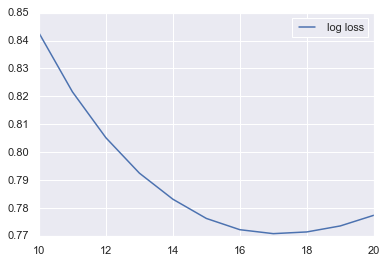

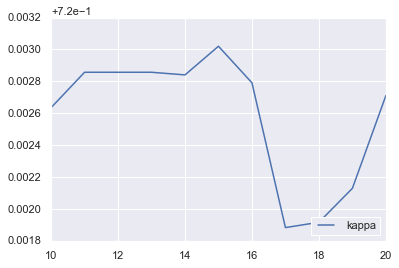

In [46]:
plt.plot(r, errors, label = "log loss")
plt.legend(loc='upper right')
plt.show()
#plt.plot(r, La, label = "accuracy")
plt.plot(r, Lk, label = "kappa")
plt.legend(loc='lower right')
plt.show()

In [43]:
errors = []
Lk = []
La = []

r = range(1, 5)


for i in r:
    xbcs = xgb.XGBClassifier(n_estimators = 17, random_state=42, learning_rate= 0.1, max_depth= i,  subsample= 0.7, 
                            n_jobs=-1)
    xbcs.fit(train_proba11, y)
    ll = log_loss(y_true, xbcs.predict_proba(test_proba11))
    errors.append(ll)
    y_pred = xbcs.predict(test_proba11)
    k=cohen_kappa_score(y_true, y_pred)
    a= accuracy_score(y_true, y_pred)
    print("depth= ", i)
    print("log loss = ", ll)
    print("kappa = ", k)
    print("accuracy = ", a)
    
    Lk.append(k)
    La.append(a)

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


depth=  1
log loss =  0.7705796844606706
kappa =  0.7221025782866585
accuracy =  0.7951147129323136


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


depth=  2
log loss =  0.7707722029271239
kappa =  0.7218828920930072
accuracy =  0.7950005707111061


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


depth=  3
log loss =  0.7707722029271239
kappa =  0.7218828920930072
accuracy =  0.7950005707111061
depth=  4
log loss =  0.7707722029271239
kappa =  0.7218828920930072
accuracy =  0.7950005707111061


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


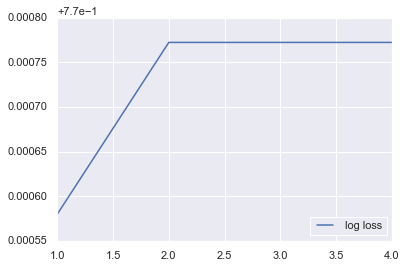

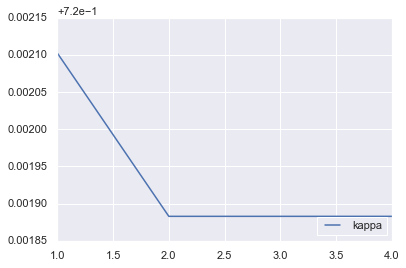

In [44]:
plt.plot(r, errors, label = "log loss")
plt.legend(loc='lower right')
plt.show()
#plt.plot(r, La, label = "accuracy")
plt.plot(r, Lk, label = "kappa")
plt.legend(loc='lower right')
plt.show()

In [55]:
errors = []
Lk = []
La = []

r = range(1, 11)


for i in r:
    xbcs = xgb.XGBClassifier(n_estimators = 17, random_state=42, learning_rate= 0.1, max_depth= 2,  subsample= i/10, 
                            n_jobs=-1)
    xbcs.fit(train_proba11, y)
    ll = log_loss(y_true, xbcs.predict_proba(test_proba11))
    errors.append(ll)
    y_pred = xbcs.predict(test_proba11)
    k=cohen_kappa_score(y_true, y_pred)
    a= accuracy_score(y_true, y_pred)
    print("subsample ", i/10)
    print("log loss = ", ll)
    print("kappa = ", k)
    print("accuracy = ", a)
    
    Lk.append(k)
    La.append(a)

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


subsample  0.1
log loss =  0.7732274554888416
kappa =  0.7191428350907432
accuracy =  0.7930601529505764


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


subsample  0.2
log loss =  0.7707632925208744
kappa =  0.721079840508342
accuracy =  0.7943157173838603


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


subsample  0.3
log loss =  0.7678237629051065
kappa =  0.7220827372996401
accuracy =  0.7951147129323136


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


subsample  0.4
log loss =  0.768235843676694
kappa =  0.7221159644411517
accuracy =  0.7951147129323136


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


subsample  0.5
log loss =  0.768259534231945
kappa =  0.7230393385583629
accuracy =  0.7957995662595594


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


subsample  0.6
log loss =  0.7683464211390832
kappa =  0.7216872430782806
accuracy =  0.7947722862686908


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


subsample  0.7
log loss =  0.7707722029271239
kappa =  0.7218828920930072
accuracy =  0.7950005707111061


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


subsample  0.8
log loss =  0.7730607722546056
kappa =  0.7215697103734469
accuracy =  0.7947722862686908


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


subsample  0.9
log loss =  0.7762292236423073
kappa =  0.7234478690403868
accuracy =  0.7962561351443899
subsample  1.0
log loss =  0.7779861453709273
kappa =  0.7192538901301873
accuracy =  0.7932884373929917


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


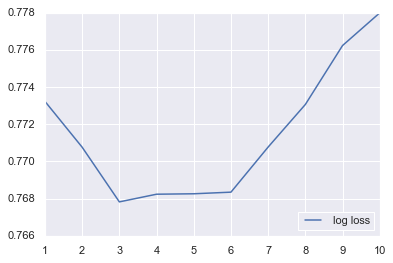

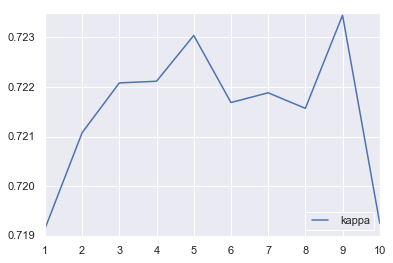

In [56]:
plt.plot(r, errors, label = "log loss")
plt.legend(loc='lower right')
plt.show()
#plt.plot(r, La, label = "accuracy")
plt.plot(r, Lk, label = "kappa")
plt.legend(loc='lower right')
plt.show()

#### let's try by stacking logistic regression

In [70]:
train_proba11.shape

(35059, 55)

In [64]:
def predwake(X, y, X_test, y_true, L=[0.001, 0.01, 0.1, 1, 10, 100]):
    Lkappa_l1 = []
    Lkappa_l2 = []
    Lsparsity_l1 = []
    Lsparsity_l2 = []
    Lrecall_l1 = []
    Lrecall_l2 = []
    Lprecision_l1 = []
    Lprecision_l2 = []
    for C in L: 
        l1_LR = LogisticRegression(C=C, penalty='l1', tol=0.01, solver='liblinear')
        l2_LR = LogisticRegression(C=C, penalty='l2', tol=0.01, solver='liblinear')
        l1_LR.fit(X, y)
        l2_LR.fit(X, y)
        y_pred_l1 = l1_LR.predict(X_test)
        y_pred_l2 = l2_LR.predict(X_test)
        coef_l1_LR = l1_LR.coef_.ravel()
        coef_l2_LR = l2_LR.coef_.ravel()
        sparsity_l1_LR = np.mean(coef_l1_LR == 0) * 100
        sparsity_l2_LR = np.mean(coef_l2_LR == 0) * 100
        kappa_l1 = cohen_kappa_score(y_true, y_pred_l1)
        kappa_l2 = cohen_kappa_score(y_true, y_pred_l2)
        #
        Lsparsity_l1.append(sparsity_l1_LR)
        Lsparsity_l2.append(sparsity_l2_LR)

        Lkappa_l1.append(kappa_l1)
        Lkappa_l2.append(kappa_l2)
 
#        notScarseCoefs = []
#        for i in range(0, len(coef_l1_LR)):
#            if (coef_l1_LR[i] !=0):
#                notScarseCoefs.append(X.columns[i])
    fig, ax = plt.subplots()
    ax.set_title("Sparsity vs C for l1")
    ax.semilogx(L, Lsparsity_l1)
    plt.show()
    fig, ax = plt.subplots()
    ax.set_title("Sparsity vs C for l2")
    ax.semilogx(L, Lsparsity_l2)
    plt.show()
    
               
    fig, ax = plt.subplots()
    ax.set_title("kappa vs C for l1 (blue') and l2 (red)")
    ax.semilogx(L, Lkappa_l1, color= 'b')
    #plt.legend(loc='upper right')
    ax.semilogx(L, Lkappa_l2, color = 'r')
    plt.show()
    return [Lkappa_l1, Lkappa_l2]

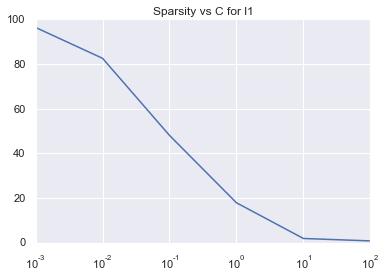

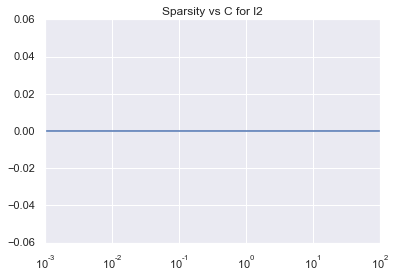

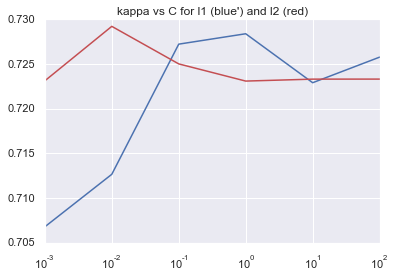

[[0.7067599455682856,
  0.7126421343449336,
  0.7272209732384451,
  0.7283850332087984,
  0.7229005159334516,
  0.725766505635072],
 [0.7231129093471624,
  0.7292136441528991,
  0.7250077583834457,
  0.723084278072121,
  0.7233016581325658,
  0.7233062384513378]]

In [65]:
predwake(X, y, X_test, y_true)

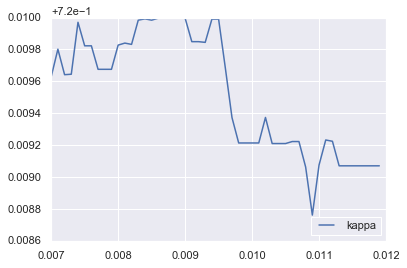

In [67]:

#predwake(X, y, X_test, y_true)
L = list(pd.Series(range(70, 120))/10000)
Lkappa_l2 = []

for C in L: 
    
    l2_LR = LogisticRegression(C=C, penalty='l2', tol=0.01, solver='liblinear')
 
    l2_LR.fit(X, y)
    y_pred_l2 = l2_LR.predict(X_test)


    kappa_l2 = cohen_kappa_score(y_true, y_pred_l2)
    Lkappa_l2.append(kappa_l2)


plt.plot(L, Lkappa_l2, label = "kappa")
plt.legend(loc='lower right')
plt.show()

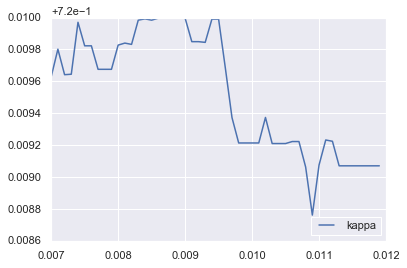

In [68]:

plt.plot(L, Lkappa_l2, label = "kappa")
plt.legend(loc='lower right')
plt.show()

In [89]:
l2_LR = LogisticRegression(C=0.009, penalty='l2', tol=0.01, solver='liblinear')
l2_LR.fit(train_proba11, y)
y_pred_l2 = l2_LR.predict(test_proba11)
kappa_l2 = cohen_kappa_score(y_true, y_pred_l2)
print(kappa_l2)

0.7295425544577583
